In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sb
from sklearn.model_selection import train_test_split

In [3]:
# Load and prepare the data

In [4]:
df = pd.read_csv("datasets/telegram_spam.csv")

In [5]:
df

,text_type,text
0,spam,naturally irresistible your corporate identity...
1,spam,the stock trading gunslinger fanny is merrill ...
2,spam,unbelievable new homes made easy im wanting to...
3,spam,4 color printing special request additional in...
4,spam,do not have money get software cds from here s...
...,...,...
20343,ham,/ban
20344,ham,/ban
20345,ham,/ban
20346,ham,Kaisi hii


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20348 entries, 0 to 20347
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text_type  20348 non-null  object
 1   text       20348 non-null  object
dtypes: object(2)
memory usage: 318.1+ KB


In [7]:
text_count = df["text_type"].value_counts()

([<matplotlib.patches.Wedge at 0x20b2d48fa10>,
 [Text(-0.6593290526271378, 0.8805028111038606, 'spam'),
  Text(0.6593290526271383, -0.8805028111038605, 'ham')],
 [Text(-0.35963402870571154, 0.48027426060210576, '70.5%'),
  Text(0.3596340287057117, -0.4802742606021057, '29.5%')])

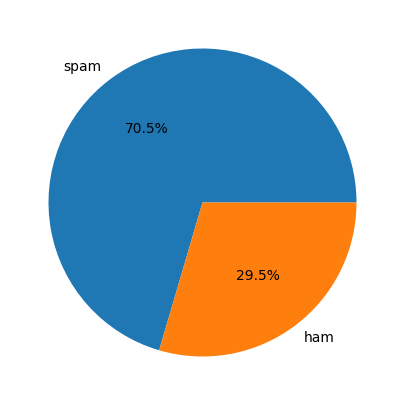

In [8]:
plt.figure(figsize=(5, 5))
plt.pie(text_count, labels=df["text_type"].unique(), autopct='%1.1f%%')

In [9]:
df["text_type"] = df["text_type"].map({"spam": 1, "ham": 0})

In [10]:
df

,text_type,text
0,1,naturally irresistible your corporate identity...
1,1,the stock trading gunslinger fanny is merrill ...
2,1,unbelievable new homes made easy im wanting to...
3,1,4 color printing special request additional in...
4,1,do not have money get software cds from here s...
...,...,...
20343,0,/ban
20344,0,/ban
20345,0,/ban
20346,0,Kaisi hii


In [11]:
X, y = df["text"], df["text_type"]

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

In [35]:
counter = CountVectorizer(max_features=20000, stop_words='english')

In [36]:
X_vect = counter.fit_transform(X)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, random_state=42, test_size=0.15)

In [38]:
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)
print("y_train shape", y_train.shape)
print("y_test shape", y_test.shape)

X_train shape (17295, 20000)
X_test shape (3053, 20000)
y_train shape (17295,)
y_test shape (3053,)


In [39]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [40]:
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [41]:
# Build a model

In [108]:
import torch.nn as nn
class BinaryClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.f1 = nn.Linear(X_train.shape[1], 512)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.f2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)
        
        self.f3 = nn.Linear(256, 128)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=0.5)

        self.f4 = nn.Linear(128, 1)
       

    def forward(self, x):
        x = self.dropout1(self.relu1(self.f1(x))) 
        x = self.dropout2(self.relu2(self.f2(x)))
        x = self.dropout3(self.relu3(self.f3(x)))
        x = torch.sigmoid(self.f4(x))
        return x
        

In [109]:
model = BinaryClassificationModel()
loss_fn = nn.BCELoss() 
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [110]:
epochs = 50
best_test_loss = float('inf')
current_patience = 0
patience = 1

for epoch in range(epochs):
    model.train()
    y_pred = model(X_train_tensor)
    train_loss = loss_fn(y_pred.squeeze(), y_train_tensor)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        test_pred = model(X_test_tensor)
        test_loss = loss_fn(test_pred.squeeze(), y_test_tensor)
        
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            current_patience = 0  
        else:
            current_patience += 1 
        
            
    if epoch % 2 == 0:
        print(f"Epoch = {epoch}, train loss = {train_loss}, test loss = {test_loss}")
        
    if current_patience >= patience:
        print("Early stopping!")
        break

Epoch = 0, train loss = 0.6958870887756348, test loss = 0.6859508752822876
Epoch = 2, train loss = 0.6730955243110657, test loss = 0.653446614742279
Epoch = 4, train loss = 0.6237690448760986, test loss = 0.5876327157020569
Epoch = 6, train loss = 0.5445835590362549, test loss = 0.5083146691322327
Epoch = 8, train loss = 0.47134315967559814, test loss = 0.4487944543361664
Epoch = 10, train loss = 0.4095219671726227, test loss = 0.39511293172836304
Epoch = 12, train loss = 0.35039469599723816, test loss = 0.33999061584472656
Epoch = 14, train loss = 0.2950398623943329, test loss = 0.2903482913970947
Epoch = 16, train loss = 0.245168998837471, test loss = 0.24890117347240448
Epoch = 18, train loss = 0.19855085015296936, test loss = 0.21473751962184906
Epoch = 20, train loss = 0.15623600780963898, test loss = 0.18910512328147888
Epoch = 22, train loss = 0.11854775995016098, test loss = 0.17557580769062042
Epoch = 24, train loss = 0.0893750786781311, test loss = 0.17511989176273346
Early s

In [111]:
from tensorflow import keras
from keras.layers import Dense, Dropout

In [112]:
model_tf = keras.Sequential([
    keras.layers.Dense(512, activation="relu", input_shape=(X_train.shape[1], )),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation="sigmoid")
])

In [113]:
model_tf.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 512)                 │      10,240,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,404,865 (39.69 MB)

 Trainable params: 10,404,865 (39.69 MB)

 Non-trainable params: 0 (0.00 B)

In [114]:
early_stop = keras.callbacks.EarlyStopping(patience=1, monitor="val_loss")
model_tf.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history = model_tf.fit(X_train, y_train, epochs=10, validation_split=0.1, callbacks=[early_stop])

Epoch 1/10
487/487 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.8566 - loss: 0.3311 - val_accuracy: 0.9566 - val_loss: 0.1269
Epoch 2/10
201/487 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9844 - loss: 0.0523

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].plot(history.history['loss'], label='Train')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].set_title('Model loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='upper left')
ax[0].grid(True)

ax[1].plot(history.history['accuracy'], label='Train')
ax[1].plot(history.history['val_accuracy'], label='Validation')
ax[1].set_title('Model accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend(loc='upper left')
ax[1].grid(True)
plt.show()

In [ ]:
model_tf.save("telegram_spam.keras")